In [1]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.6 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yu0aj3jp
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yu0aj3jp
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=bbac2062671932b6610505283b209940941f8239da147e368ee14b1a231723d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-wgx12gjz/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [2]:
import numpy as np
import torch
from pkg_resources import packaging

print("Torch version:", torch.__version__)

Torch version: 2.1.0+cu121


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading the model

In [4]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [5]:
model, preprocess = clip.load("RN50")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

100%|████████████████████████████████████████| 244M/244M [00:02<00:00, 109MiB/s]


Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


## Image preprocessing

In [6]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7a4a2f46fb50>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

## Text preprocessing

In [7]:
clip.tokenize("We are a bass connections team!")

tensor([[49406,   649,   631,   320,  5992, 37161,  1027,   256, 49407,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

## Setting up input images and texts

In [8]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

In [9]:
from torchvision import transforms, models, datasets

# Define transform
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load EuroSAT dataset
data_dir = '/content/drive/MyDrive/Train_Test_Splits'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), transform) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, shuffle=True, num_workers=4) for x in ['train', 'test']}

In [10]:
from tqdm import tqdm
model.eval()

# Dictionary to store embeddings and image paths
embeddings = []
images = []
image_labels=[]
for inputs, labels in tqdm(dataloaders['train']):
    inputs = inputs.to('cuda')

    with torch.no_grad():
        features = model.encode_image(inputs).detach().cpu()

    # Store embeddings
    for i in range(inputs.size(0)):
        images.append(inputs[i].cpu().numpy())
        embeddings.append(features[i].numpy())
        image_labels.append(labels[i].cpu().numpy())

100%|██████████| 338/338 [19:02<00:00,  3.38s/it]


In [54]:
def interpolate_embeddings(embedding1, embedding2, steps):
    interpolation_factors = np.linspace(0, 1, steps)
    interpolated_embeddings = []
    for factor in interpolation_factors:
        interpolated_embedding = embedding1 + factor * (embedding2 - embedding1)
        interpolated_embeddings.append(interpolated_embedding)
    return interpolated_embeddings

def find_unique_closest_vectors(index_give, all_vecs):
    """
    Find unique closest vectors from the set of all vectors to the intermediate points.
    :param given_vec: The vector from which distances are measured.
    :param all_vecs: A list of vectors to compare against the given vector.
    """
    # Calculate distances from the given vector to all other vectors
    distances = [np.linalg.norm(all_vecs[index_give] - vec) for vec in all_vecs]

    # Find the index of the maximum distance
    max_distance_idx = np.argmax(distances)

    # Initialize set to keep track of chosen indices
    chosen_indices = {max_distance_idx,index_give}

    # Get the vector with the maximum distance
    max_distance_vec = all_vecs[max_distance_idx]

    # Generate evenly spaced points between given_vec and max_distance_vec
    step = (max_distance_vec - all_vecs[index_give]) / 10
    intermediate_points = [all_vecs[index_give] + i * step for i in range(1, 11)]

    # Find the nearest unique vector index in all_vecs for each intermediate point
    closest_vector_indices = [index_give]  # Start with the max distance index
    for point in intermediate_points:
        min_distance = float('inf')
        closest_idx = -1
        for idx, vec in enumerate(all_vecs):
            if idx not in chosen_indices:
                distance = np.linalg.norm(point - vec)
                if distance < min_distance:
                    min_distance = distance
                    closest_idx = idx
        closest_vector_indices.append(closest_idx)
        chosen_indices.add(closest_idx)
    closest_vector_indices.append(max_distance_idx)

    return closest_vector_indices

In [44]:
# dictionary for labels
dict_label = {0: 'AnnualCrop', 1: 'Forest', 2: 'HerbaceousVegetation', 3: 'Highway',
              4: 'Industrial', 5: 'Pasture', 6: 'PermanentCrop',
              7: 'Residential', 8: 'River', 9: 'SeaLake'}

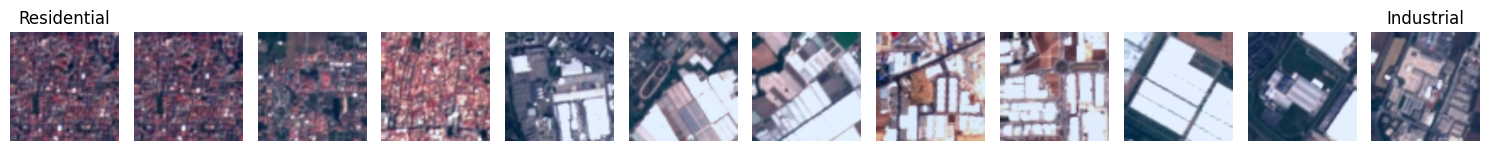

In [69]:
from skimage import exposure

# Visualize linear interpolation
index1 = np.random.randint(0, len(embeddings))
index2 = np.random.randint(0, len(embeddings))
embedding1 = embeddings[index1]
embedding2 = embeddings[index2]
interpolated_embeddings = interpolate_embeddings(embedding1, embedding2, 10)

plt.figure(figsize=(15, 10))

plt.subplot(1, 12, 1)
original_image1 = np.transpose(images[index1], (1, 2, 0))
adjusted_image1 = exposure.rescale_intensity(original_image1, in_range='image', out_range=(0.0, 1.0))
plt.imshow(adjusted_image1)
plt.title(dict_label[int(image_labels[index1])])
plt.axis('off')

plt.subplot(1, 12, 12)
original_image2 = np.transpose(images[index2], (1, 2, 0))
adjusted_image2 = exposure.rescale_intensity(original_image2, in_range='image', out_range=(0.0, 1.0))
plt.imshow(adjusted_image2)
plt.title(dict_label[int(image_labels[index2])])
plt.axis('off')

for i, closest_vector in enumerate(interpolated_embeddings):
    closest_index = np.argmin(np.linalg.norm(embeddings - closest_vector, axis=1))
    closest_vectors = find_unique_closest_vectors(closest_index, embeddings)
    plt.subplot(1, 12, 2 + i)
    original_image = np.transpose(images[closest_vectors[i]] , (1, 2, 0))
    adjusted_image = exposure.rescale_intensity(original_image, in_range='image', out_range=(0.0, 1.0))
    plt.imshow(adjusted_image)
    plt.axis('off')

plt.tight_layout()
plt.show()